# overview 

In [ ]:
# importing sys
import sys
  
# adding srcpy to the system path
sys.path.insert(0, "/Users/charles/Desktop/DSAI/6_DataScience/project/DSP/zr1/src/srcpy")

import data_proc

# Auto reload: watch a directory for changed files and restarts a process when the change is detected
%load_ext autoreload
%autoreload 2

In [55]:
import random
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
mpl.style.use("ggplot")
pylab.rcParams["figure.figsize"] = 8 , 6

import seaborn as sns
sns.set_style("white")

from pandas_profiling import ProfileReport

In [98]:
df = data_proc.load_training_data("/Users/charles/Desktop/DSAI/6_DataScience/project/DSP/20221/data/zillow.csv")
df = df.drop(['Unnamed: 0', "type", "rent_zestimate", "zestimate", "broker_name", "full_bathrooms"], axis=1)
df.head()

,price,status,has_add_attributions,city,state,latitude,longitude,bathrooms,bedrooms,living_area,lot_area,tax_assessed_value,num_fireplaces,parking,covered_spaces,garage_spaces,total_spaces,lot_features,subtype,architectural_style,year_built,sewer_info,water_info,appliances,heating,cooling,stories,materials,roof,foundation,interior_features,compensation
0,274000,House for sale,True,South Ozone Park,NY,40.675730,-73.822350,1,3,1556,2400.0,0,none,Garage - Detached,1.750,1.595,1.945,none,none,none,1930.0,none,none,none,none,none,0.0,none,none,none,none,none
1,270000,House for sale,True,Jamaica,NY,40.670036,-73.780450,2,4,1920,3998.0,678000,none,none,1.660,1.535,2.160,none,none,none,1950.0,none,none,microwave,none,none,0.0,none,none,none,none,none
2,899000,House for sale,True,Staten Island,NY,40.524227,-74.215790,3,3,2532,6903.0,637000,none,Detache,1.935,2.000,2.000,none,Single Family - Detached,Colonial,1899.0,Public Sewer,none,dishwasher,hot water,Units,2.0,none,none,none,none,none
3,1390000,House for sale,True,Flushing,NY,40.721615,-73.820755,4,4,1915,2697.0,894000,none,none,1.695,1.655,3.915,none,none,none,1945.0,none,none,dryer,none,none,0.0,none,none,none,none,none
4,1390000,House for sale,True,Flushing,NY,40.721615,-73.820755,4,4,1915,2697.0,0,none,Shared Drivewa,1.540,1.000,3.705,Near Public Transit,Single Family Residence,Semi Detached,1945.0,Public Sewer,Public,none,natural gas,Wall Unit(s),3.0,frame,none,none,Eat-in Kitche,none


# check destiny & histogram

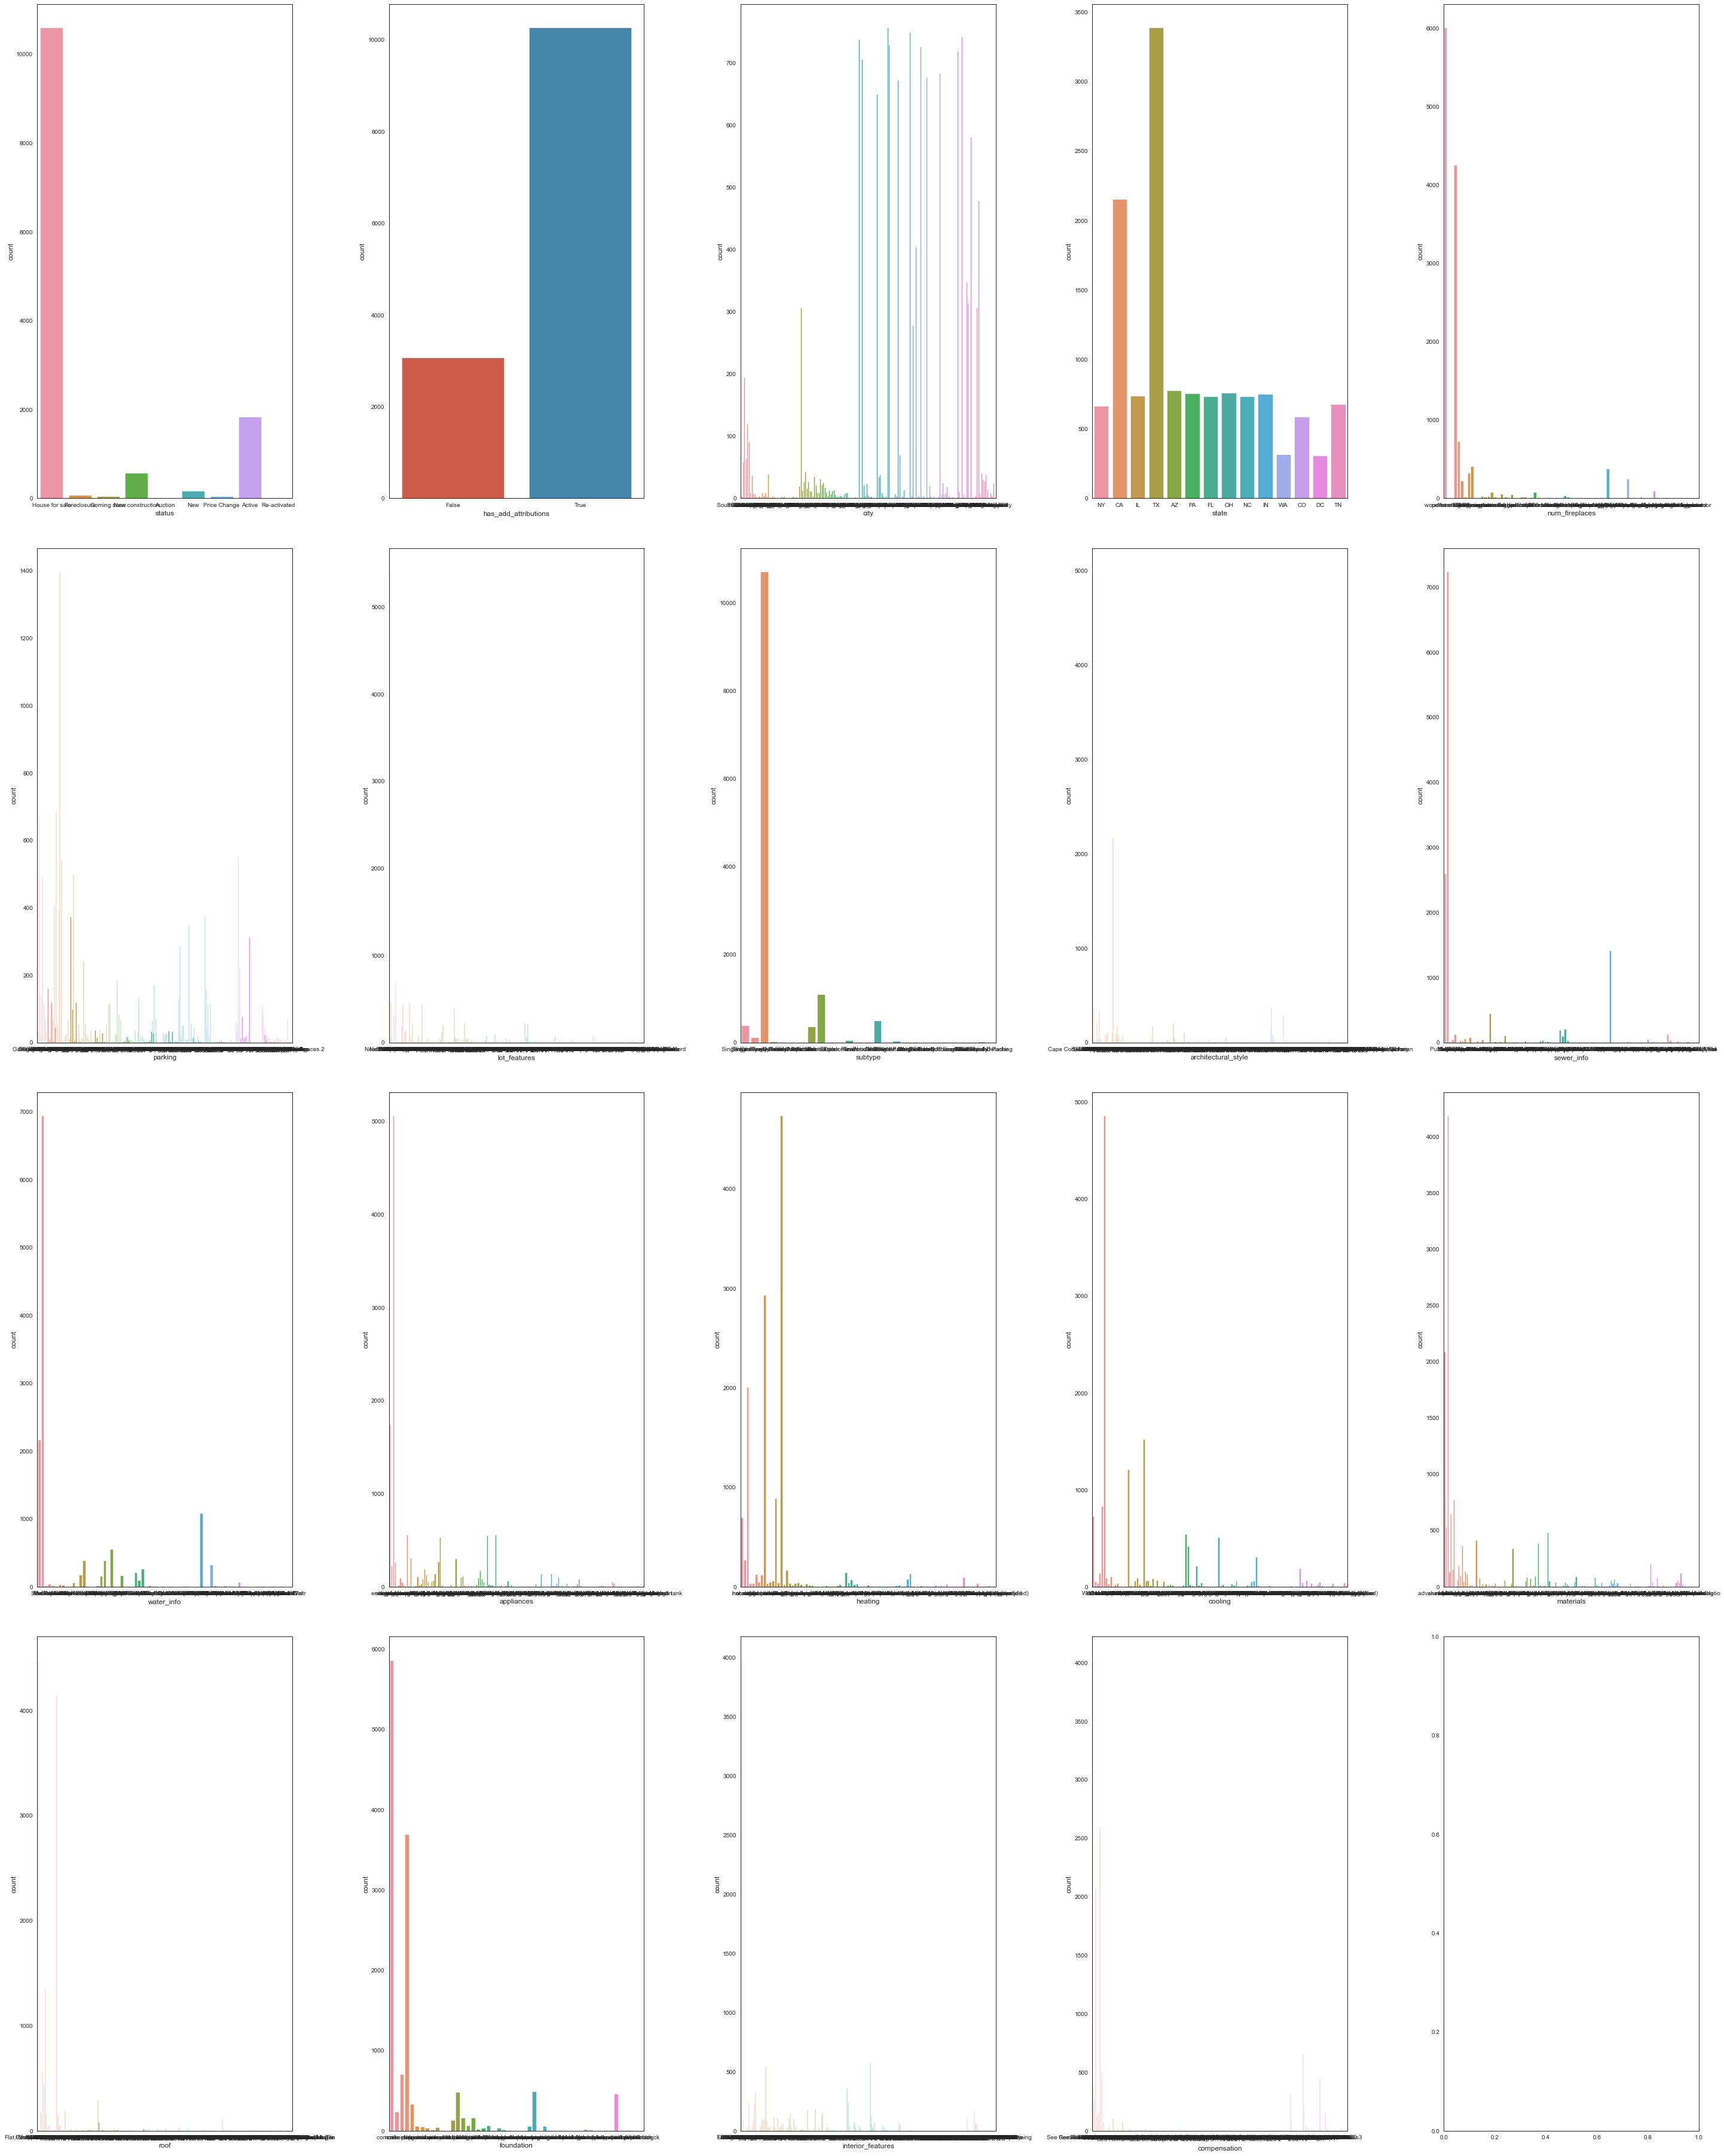

In [91]:
# Destiny
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(40, 50))
index = 0
axs = axs.flatten()
for k,v in df.select_dtypes(exclude='number').items():
    sns.countplot(v, ax=axs[index])
    index += 1
    if index == 20:
        break
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show();

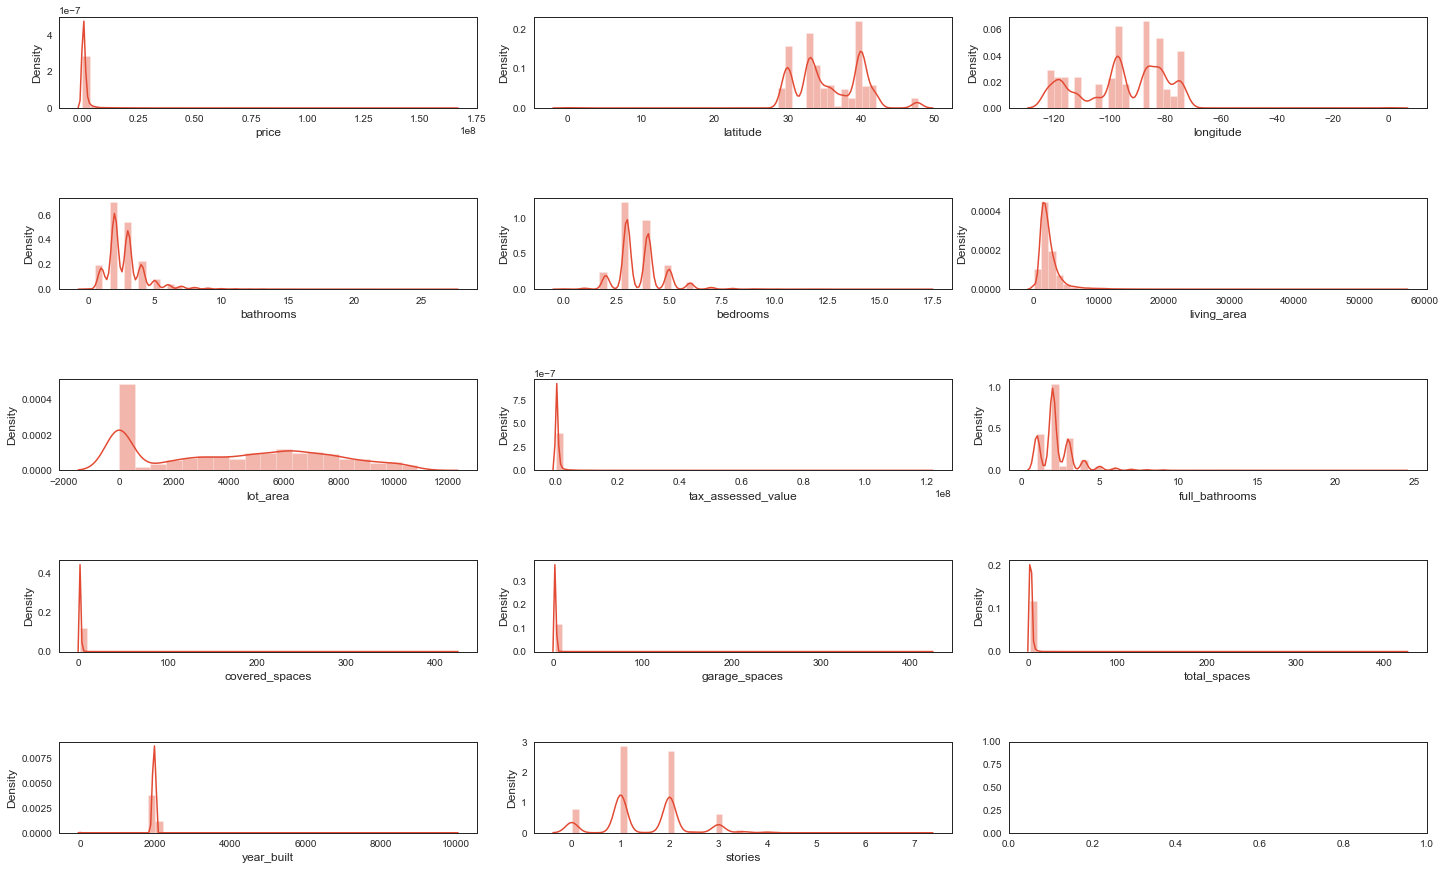

In [97]:
# Destiny
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(nrows = 5, ncols = 3, figsize=(20, 12))
index = 0
axs = axs.flatten()
for k,v in df.select_dtypes(include='number').items():
    sns.distplot(v, ax=axs[index])
    index += 1
    if index == 15:
        break
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show();

# remove outliers

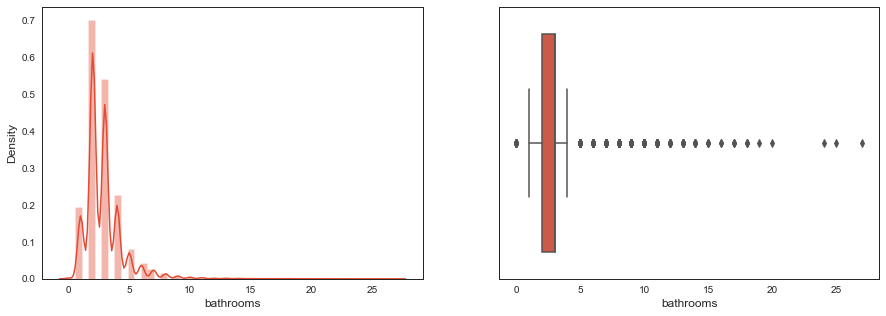

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(df["bathrooms"],  ax=axs[0]);
sns.boxplot(df["bathrooms"],  ax=axs[1]);

In [95]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin

def find_boxplot_boundaries(df_col):
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR   # ≥ 0 for this feature
    upper = Q3 + 1.5 * IQR
    return lower, upper

# OOP Inheritance
class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lower = None
        self.upper = None

    def fit(self, df_col):
        self.lower, self.upper = find_boxplot_boundaries(df_col)
        return self

    def transform(self, df_col):
        return df_col.clip(self.lower, self.upper)


find_boxplot_boundaries(df["bathrooms"])

(0.5, 4.5)

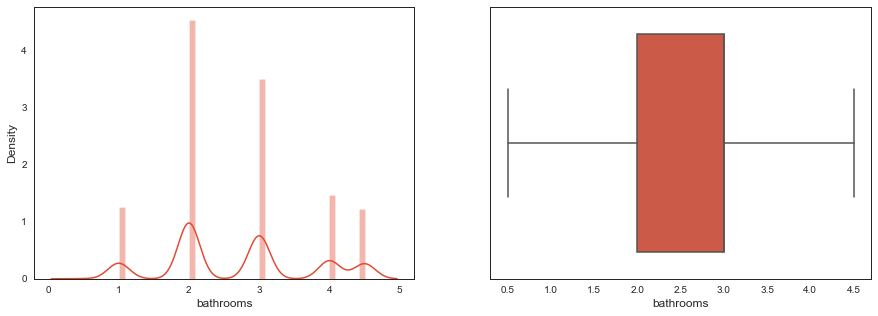

In [96]:
#clipped_total_rooms = BoxplotOutlierClipper().fit(df_housing["total_rooms"]).transform(df_housing["total_rooms"])
clipped_bathrooms = BoxplotOutlierClipper().fit_transform(df["bathrooms"])

# Plot new data (clipped)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(clipped_bathrooms, ax = axs[0])
sns.boxplot(clipped_bathrooms, ax = axs[1]);

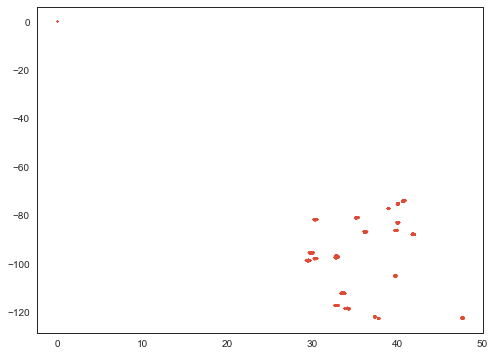

In [92]:
plt.scatter(df.latitude, df.longitude, s=1);

In [44]:
df["broker_name"]

0                            Listing by: SOWAE CORP
1                            Listing by: SOWAE CORP
2        Listing by: Comfort Homes Realty Group Inc
3                    Listing by: Winzone Realty Inc
4                    Listing by: Winzone Realty Inc
                            ...                    
13334                      Bennett Realty Solutions
13335                           RE/MAX Gateway, LLC
13336               Long & Foster Real Estate, Inc.
13337                               Northrop Realty
13338                          Evergreen Properties
Name: broker_name, Length: 13339, dtype: object

In [47]:
df["price"].()

AttributeError: 'Series' object has no attribute 'info'

In [29]:
df.columns

Index(['price', 'status', 'broker_name', 'has_add_attributions', 'city',
       'state', 'latitude', 'longitude', 'bathrooms', 'bedrooms',
       'living_area', 'lot_area', 'rent_zestimate', 'zestimate',
       'tax_assessed_value', 'full_bathrooms', 'num_fireplaces', 'parking',
       'covered_spaces', 'garage_spaces', 'total_spaces', 'lot_features',
       'subtype', 'architectural_style', 'year_built', 'sewer_info',
       'water_info', 'appliances', 'heating', 'cooling', 'stories',
       'materials', 'roof', 'foundation', 'interior_features', 'compensation'],
      dtype='object')

In [40]:
df["rent_zestimate"].value_counts()

0        4094
2499      114
2999       94
1999       91
4500       80
         ... 
3746        1
6755        1
13989       1
1715        1
5146        1
Name: rent_zestimate, Length: 3697, dtype: int64